<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/tmcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import multivariate_normal, norm
from numpy.linalg import cholesky
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import logging

In [2]:
# Function to compute beta and weights
def _beta_and_weights(beta, adjusted_likelihood):
    low = beta
    high = 2

    while (high - low) / ((high + low) / 2) > 1e-6 and high > np.finfo(float).eps:
        x = (high + low) / 2
        w = np.exp((x - beta) * adjusted_likelihood)

        if np.std(w) / np.mean(w) > 1:
            high = x
        else:
            low = x

    return min(1, x), w

In [3]:
# Function to generate proposals
def proprnd(mu, cov_matrix, prior):
    while True:
        sample = multivariate_normal.rvs(mean=mu, cov=cov_matrix)
        if not np.isinf(prior(sample)):
            return sample

In [4]:
# Function to run Metropolis-Hastings
def metropolis_hastings_simple(target, proposal, x0, n_samples, burnin=10, thin=3):
    samples = []
    x = x0
    for _ in range(n_samples * thin + burnin):
        x_new = proposal(x)
        acceptance_ratio = np.exp(target(x_new) - target(x))
        if np.random.rand() < acceptance_ratio:
            x = x_new
        samples.append(x)
    return np.array(samples)[burnin::thin]

Ttransitional MarkovChain MC. Why? How does it work?



*   `M = f(x;θ)` Model class;
*   `θ` = Parameter vector;
*  ` D = {f1,...,fn} `the data;


    Model updating:
    Prob(θ|D,M) = Prob(D|θ,M) · Prob(θ|M) / Prob(D|M)

    Prob(D|M) := evidence (normalizing constant)
    Prob(θ|M) := prior on model params
    Prob(D|θ,M) := likelihood of Data given model and model params
    Prob(θ|D,M) := posterior on model params given Data and model class
-

    Approximated Bayesian Computation (AABC)

    Prob(θ|D,M) \propto Prob(D|θ,M) · Prob(θ|M)

    Prob(D|θ,M):= pseudo likelihood
$\propto exp(-\frac{d(D,M(\theta))^2}{\epsilon^2})$

    Approximated Transitional updating:
                Pj \propto P(θ|M) · P(D|θ,M)^βj
    βj: slowly update prior to the posterior
-


In [5]:
def tmcmc(log_fD_T, log_fT, sample_fT, Nsamples,  burnin=20, thin=3, beta2=0.01):
    """
    Transitional Markov Chain Monte Carlo (TMCMC) method for Bayesian inference.
    Adapted from Ching and Chen (2007)
    % ------------------------------------------------------------------------
    % who                    when         observations
    %--------------------------------------------------------------------------
    % Diego Andres Alvarez   Jul-24-2013  First algorithm (MATLAB)
    %--------------------------------------------------------------------------
    % Roberto Rocchetta      Dec-12-2024  Initial version (Python)
    %--------------------------------------------------------------------------

    Parameters:
    - log_fD_T: log-likelihood (log-pdf or approximated likelihood prop to -distance(Data,Model)
    - log_fT: the prior distribution (PDF)
    - sample_fT: the prior distribution (sampler)

    - Nsamples: Number of theta samples to generate.
    - beta2: Scaling factor for adaptive proposal distribution.
    - burnin: Number of burn-in steps for MCMC.

    Returns:
    - samples_posterior_pdf: Samples from the posterior distribution.
    - log_evidence: Log of the Bayesian evidence.
    """
    # Iteration number, Tempering parameter, Log Evidence
    j1, beta_j, Log_ev = 0, 0, 0
    theta_j = np.array(sample_fT(Nsamples))  # Samples of prior

    while beta_j < 1:   ##START
        j1 += 1

        # Compute likelihood
        Lp_j = np.array([log_fD_T(theta) for theta in theta_j])
        Lp_adjust = np.max(Lp_j)

        # Compute new beta and weights
        logging.info(f"'Computing beta the weights ...")
        beta_j1, w_j = _beta_and_weights(beta_j, Lp_j - Lp_adjust)
        print(f"Iteration {j1}: Tempering parameter updated to {beta_j1:.3f}")

        Log_ev += np.log(np.mean(w_j)) + (beta_j1 - beta_j) * Lp_adjust

        # Weighted resampling of theta_j
        wn_j = w_j / np.sum(w_j)  # Normalize weights
        indices = np.random.choice(range(Nsamples), size=Nsamples, p=wn_j.flatten())
        theta_j1 = theta_j[indices]

        covariance = beta2 * np.cov(theta_j1, rowvar=False)  # Estimate covariance matrix

        # Define proposal and target functions
        proposal = lambda mu: proprnd(mu, covariance, log_fT)
        target = lambda x: beta_j1 * log_fD_T(x) + log_fT(x)

        # Run Markov chains posterior sampling
        theta_j1 = np.array([
                    metropolis_hastings_simple(target, proposal, theta, 1, burnin=burnin, thin=thin)[0]
                    for theta in tqdm(theta_j1, desc="Running MH - Markov Chains")])

        beta_j = beta_j1
        theta_j = theta_j1

    return theta_j, Log_ev

In [6]:
# Generate the Two Moons dataset
def generate_two_moons(n_samples=100, noise=0.1):
    theta = np.linspace(0, np.pi, n_samples // 2)
    x1 = np.cos(theta)
    y1 = np.sin(theta)

    x2 = 1 - np.cos(theta)
    y2 = -np.sin(theta)

    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])

    x += noise * np.random.randn(n_samples)
    y += noise * np.random.randn(n_samples)

    return np.column_stack([x, y])

# Generate outputs based on a quadratic function
def model(xa, xe, xc):
    a, b, c = xe[0], xe[1], xc[0]
    x, y = xa[:, 0], xa[:, 1]

    o1 = a * x ** 2 + b * y + c
    o2 = a * y ** 2 + (b + c) * x + c
    o3 = 1 / a * (b * y + c * x) ** 2
    return np.array([o1, o2, o3]).T




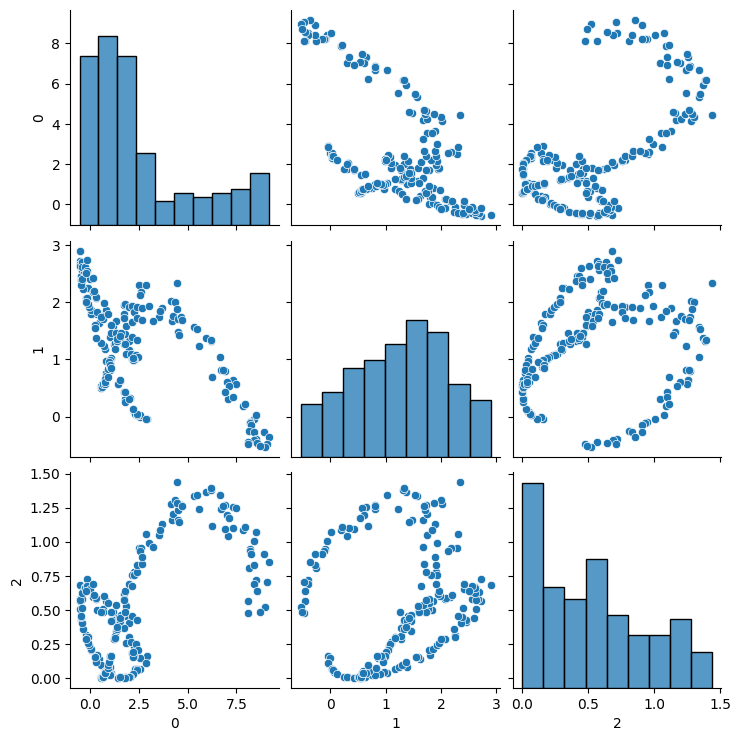

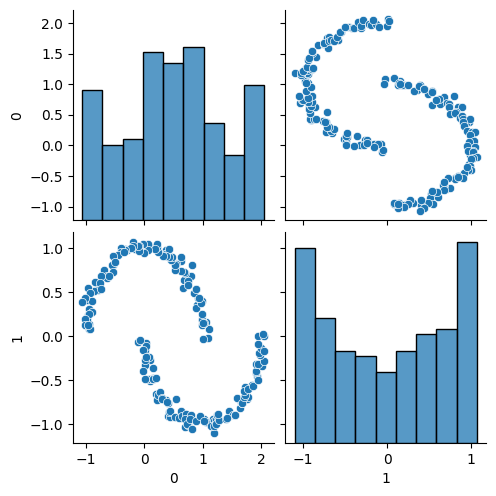

In [7]:
    # Generative model for  Xa (unknown stochastic/aleatory sources of uncertainty)

    n_samples = 200
    Xa = generate_two_moons(n_samples=n_samples, noise=0.05)

    # Ture epistemic uncertain parameters, Xe (unknown but fixed in the system or model)
    Xe = [2.0, -1.0]

    # unknown model parameters, e.g., control, Xc
    Xc = [0.5]

    # generate data set of model outputs
    Data_empirical = model(Xa, Xe, Xc)

    sns.pairplot(pd.DataFrame(Data_empirical))
    plt.show()

    # unknown uncertain inputs
    sns.pairplot(pd.DataFrame(Xa))
    plt.show()

In [8]:
# __________________________    Define epistemic variables

epistemic_domain = {
                    'Xe_1': (+1.8, +2.2),  # X epistemic 1 (lower, upper)
                    'Xe_2': (-1.4, -0.9),  # X epistemic 2 (lower, upper)
                    'Xa1_mu1': (-1, 2),  # Xa mean var 1 Gaussian_mixture, comp 1 (lower, upper)
                    'Xa1_mu2': (-1, 2),  # Xa mean var 1 Gaussian_mixture, comp 2 (lower, upper)
                    'Xa1_mu3': (-1, 2),  # Xa mean var 1 Gaussian_mixture, comp 1 (lower, upper)
                    'Xa1_mu4': (-1, 2),  # Xa mean var 1 Gaussian_mixture, comp 2 (lower, upper)
                    'Xa2_mu1': (-1, 2),  # Xa mean var 2 Gaussian_mixture, comp 1 (lower, upper)
                    'Xa2_mu2': (-1, 2),   # Xa mean var 2, Gaussian_mixture, comp 2 (lower, upper)
                    'Xa2_mu3': (-1, 2),  # Xa mean var 2 Gaussian_mixture, comp 1 (lower, upper)
                    'Xa2_mu4': (-1, 2),  # Xa mean var 2, Gaussian_mixture, comp 2 (lower, upper)
                    'Xa1_std1': (0.1, 1),  # stds... same as above...assume diag covariance
                    'Xa1_std2': (0.1, 1),  #
                    'Xa1_std3': (0.1, 1),  #
                    'Xa1_std4': (0.1, 1),  #
                    'Xa2_std1': (0.1, 1),  #
                    'Xa2_std2': (0.1, 1),  #
                    'Xa2_std3': (0.1, 1),  #
                    'Xa2_std4': (0.1, 1),  #
                  }

xe_indices = [0, 1]  # indices of the epistemic variables
lb = np.array([var[0] for var in epistemic_domain.values()])
ub = np.array([var[1] for var in epistemic_domain.values()])

In [9]:

# define the black-box physical model M combined with the distributional Model Fa model for the inputs Xa

# Define the black-box aleatory model (f_a)
def my_Aleatroy_GM_model(params_dic, n_samples: int = 200):

    np.random.seed(0)#do we need it? probably not

    # Extract parameters for the Gaussian mixture
    means = [
        [params_dic['Xa1_mu1'], params_dic['Xa2_mu1']],
        [params_dic['Xa1_mu2'], params_dic['Xa2_mu2']],
        [params_dic['Xa1_mu3'], params_dic['Xa2_mu3']],
        [params_dic['Xa1_mu4'], params_dic['Xa2_mu4']]
    ]
    stds = [
        [params_dic['Xa1_std1'], params_dic['Xa2_std1']],
        [params_dic['Xa1_std2'], params_dic['Xa2_std2']],
        [params_dic['Xa1_std3'], params_dic['Xa2_std3']],
        [params_dic['Xa1_std4'], params_dic['Xa2_std4']] # generalized to n comps?
    ]

    weights = [0.25, 0.25, 0.25, 0.25]  # assume equal weights for the Gaussian components

    samples_xa = [] # Generate samples from each Gaussian component
    for i, (mean, std) in enumerate(zip(means, stds)):
        component_samples = np.random.normal(loc=mean, scale=std, size=(int(n_samples * weights[i]), len(mean)))
        samples_xa.append(component_samples)

    # Concatenate all samples
    samples_xa = np.vstack(samples_xa) # np.random.shuffle(samples_xa)  # Shuffle the samples... not needed

    return samples_xa


def my_model(params, n_samples:int = 200):
    # this computes the probabilistic response of the balck box model that uses the Fa model as probabilistic sampler
    if not isinstance(params, list):
        if params.ndim == 1:
            params = params.reshape(1, -1)
    Model_Responses_Pars = []
    for par in params:
        params_dic = {key: val for key, val in zip(epistemic_domain.keys(), par)}
        samples_xa = my_Aleatroy_GM_model(params_dic, n_samples=n_samples)
        Model_Responses_Pars.append(model(samples_xa, par[xe_indices], Xc))
    return Model_Responses_Pars



In [10]:
from scipy.stats import wasserstein_distance, entropy, ks_2samp
from scipy.stats import norm, multivariate_normal, uniform

def pseudo_likelihood_fun(params, data, black_box_model,
                          n_samples, epsilon_width_factor = 0.5,
                          method='KL'):
    """
    Compute a pseudo-likelihood based on divergence between data and model predictions.
    Parameters:
        data (array-like): Empirical target data.
        black_box_model (function): Function that generates model predictions given params, control, and xa_samples.
        params (array-like): Model parameters to evaluate.
        method (str): Distance measure ('entropy', 'bhattacharyya', 'wasserstein').
        n_samples (int): Number of samples to generate with the model.
    Returns:
        float: Pseudo-likelihood value.
    """

    model_samples = black_box_model(params, n_samples) # Generate samples from the model
    n_bins = 20  # Number of bins
    scores = []
    for mod_sam in model_samples:
        data_hist, edges = np.histogramdd(data, bins=n_bins, density=True)
        model_hist, _ = np.histogramdd(mod_sam, bins=edges, density=True)
        # Flatten histograms for comparison + eps to avoid zero probabilities
        epsilon = 1e-10
        data_hist_flat = data_hist.flatten() + epsilon
        model_hist_flat = model_hist.flatten() + epsilon
        # Normalize to probability distributions
        data_hist_flat /= np.sum(data_hist_flat)
        model_hist_flat /= np.sum(model_hist_flat)
        if method == 'KL':  # Compute Kullback-Leibler divergence (relative entropy)
            scores.append(entropy(data_hist_flat, model_hist_flat))
        elif method == 'WS':  # Compute Wasserstein distance (Earth mover's distance)
            scores.append(wasserstein_distance(data_hist_flat, model_hist_flat))
        else:
            raise ValueError(f"Unknown method: {method}. Use 'KL', 'WS'.....")

    psd_likelihoods = -(np.array(scores) ** 2 / epsilon_width_factor ** 2) # try with loig likelihood
    return psd_likelihoods

# Define prior and likelihood
class prior_uniform:
    """ Define uniform prior distribution class"""
    def __init__(self, lb, ub):
        self.lbs = lb
        self.ubs = ub
        self.updfs = [uniform(lb, ub) for lb, ub in zip(self.lbs, self.ubs)]

        # Validate bounds and input lengths
        if len(self.lbs) != len(self.ubs):
            raise ValueError("Mismatched lengths: 'lbs', 'ubs'")
        if any(a >= b for a, b in zip(self.lbs, self.ubs)):
            raise ValueError("Each lower bound must be less than the corresponding upper bound.")

    def sample(self, N):
        return [np.random.uniform(self.lbs, self.ubs) for _ in range(N)]

    def pdf(self, thetas):
        marginal_PDF_j = [uniform(lb, ub).pdf(x) for lb, ub, x in zip(self.lbs, self.ubs, thetas)]
        return np.prod(marginal_PDF_j)

    def log_pdf(self, thetas):
        log_pdf = []
        if isinstance(thetas, list):
            for theta in thetas:
                inside_bounds = np.logical_and(self.lbs <= theta, theta <= self.ubs)
                if np.all(inside_bounds):
                    log_pdf.append(-np.sum(np.log(self.ubs - self.lbs)))
                else:
                    log_pdf.append(-np.inf)
        else:
            inside_bounds = np.logical_and(self.lbs <= thetas, thetas <= self.ubs)
            if np.all(inside_bounds):
                log_pdf.append(-np.sum(np.log(self.ubs - self.lbs)))
            else:
                log_pdf.append(-np.inf)

        return log_pdf





In [12]:
# __________________________    Define the TMCMC model
log_fD_T = lambda p: pseudo_likelihood_fun(params=p, data=Data_empirical,  black_box_model=my_model, epsilon_width_factor=0.1, n_samples=200, method='KL')
log_fT = lambda x: prior_uniform(lb, ub).log_pdf(x)
sample_fT = lambda n: prior_uniform(lb, ub).sample(n)

N_sam = 20
theta_j, Log_ev = tmcmc(log_fD_T, log_fT, sample_fT, N_sam, burnin=3, thin=2, beta2=0.01)



Iteration 1: Tempering parameter updated to 0.000


Running MH - Markov Chains: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Iteration 2: Tempering parameter updated to 0.001


Running MH - Markov Chains: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Iteration 3: Tempering parameter updated to 0.001


Running MH - Markov Chains: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


Iteration 4: Tempering parameter updated to 1.000


Running MH - Markov Chains: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


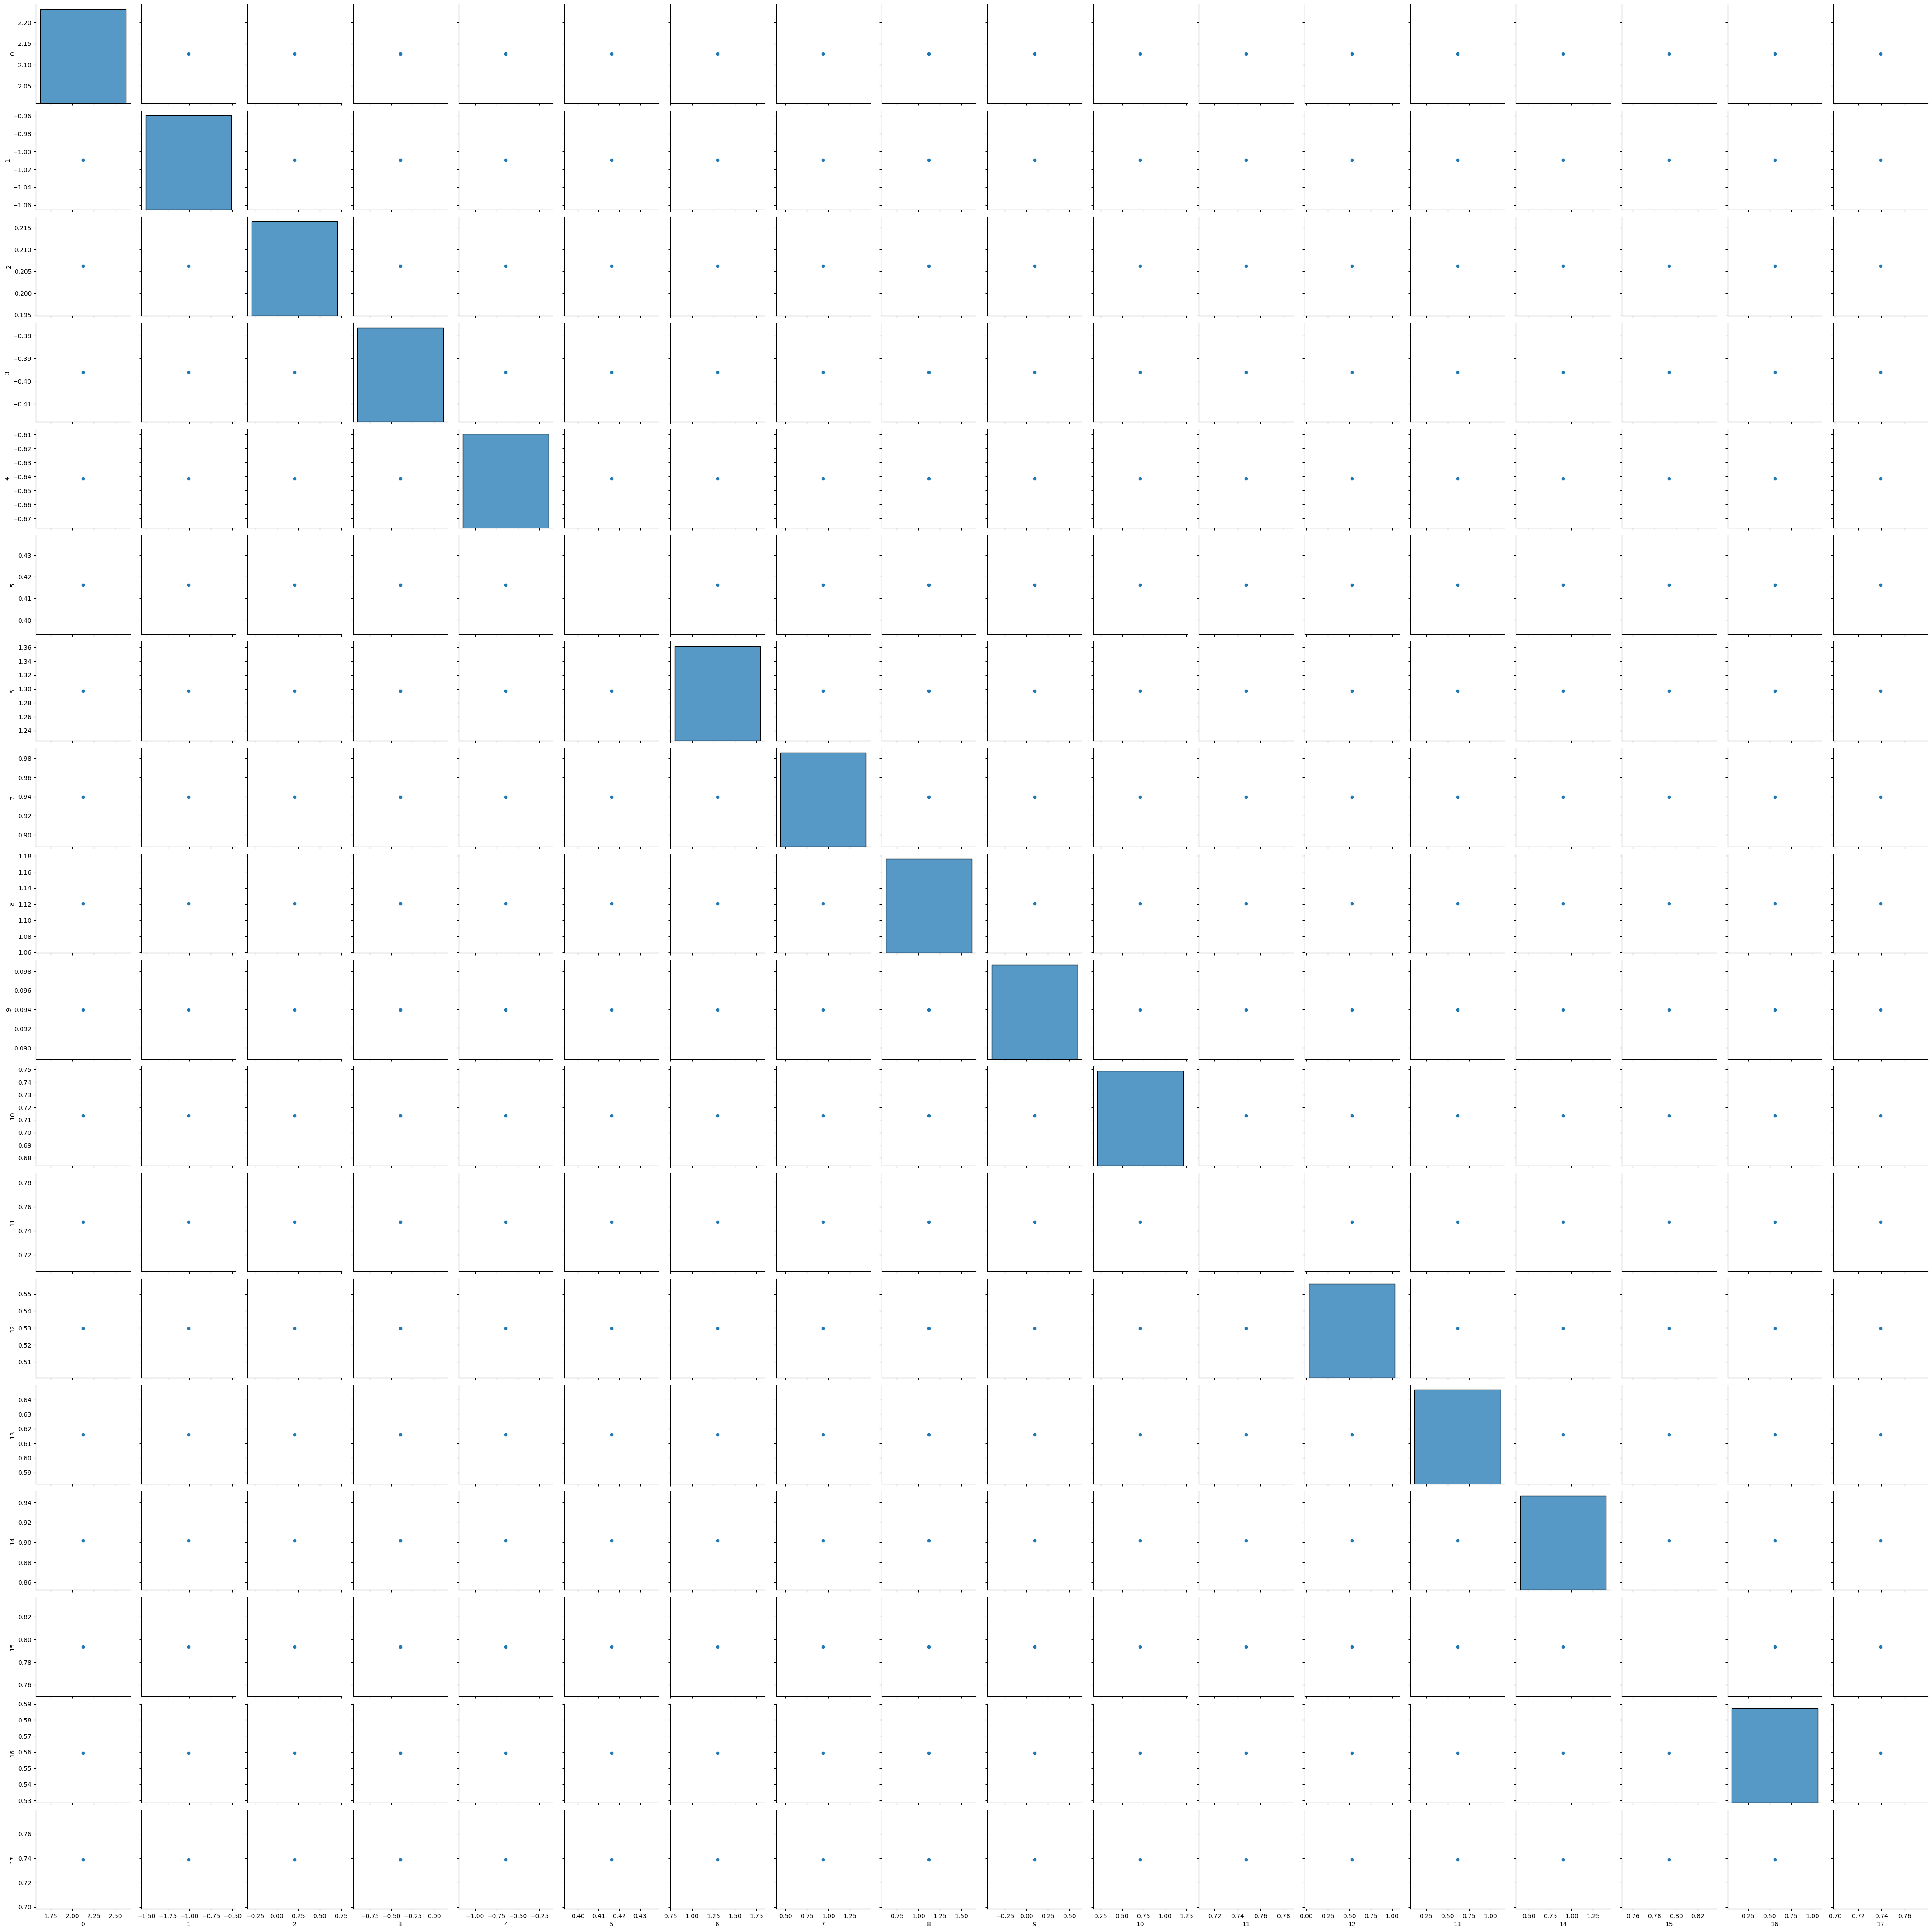

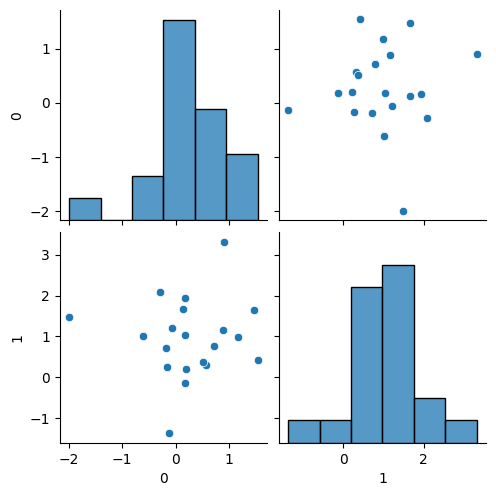

In [13]:
sns.pairplot(pd.DataFrame(theta_j))
plt.show()

params_dic = {key: val for key, val in zip(epistemic_domain.keys(), theta_j[0])}
samples_xa = my_Aleatroy_GM_model(params_dic, n_samples=N_sam)

sns.pairplot(pd.DataFrame(samples_xa))
plt.show()